# <center> Proyecto Baku - Parkinson

In [19]:
# Librerias

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage import feature
from imutils import build_montages
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import argparse
import cv2
import os
import re



from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.model_selection import cross_val_score

In [20]:
# Funciones Auxiliares

def rcb(photo):
    '''
    redimensionar imagen a 200x200
    trasforma en RGB
    Toma canal R
    Se aplica transformacion binaria
    Aplanar la imagen
    '''
    photo2 = cv2.resize(photo, (256, 256))
    photor  = cv2.cvtColor(photo2, cv2.COLOR_BGR2RGB)
    img_R = photor[:,:,0]
    ret,transformacion = cv2.threshold(img_R, 180, 255, cv2.THRESH_BINARY)
    imagef = transformacion.flatten()
    
    return imagef


def etiquetado(directorios):
    '''
    Crea las etiquetas para las imagenes 
    retorna una array con las etiquetas
    '''
    labels = []
    indice = 0
    # itelador sobre la lista de cantidades de fotos 
    for cantidad in directorios:
        for i in range(cantidad):                            # itera sore la cantidad de fotos por carpeta
            labels.append(indice)                            # etiqueta con 0 la primera carpeta con 1 la siguiente .....hasta 8
        indice = indice + 1                                  # incrementa el indice para cambiar de carpeta
    print('Cantidad etiquetas creadas: ', len(labels))
    
    return(labels)

In [21]:
def load_photos(direc):
    '''
    Ingresa la direccion de la carpeta y lee los archivos, retorna un array con las imagenes
    '''
    # se para en la carpeta datos
    dirname = os.path.join(os.getcwd(), direc) 
    imgpath = dirname + os.sep
    
    images = []                  # lista para guardar las imagenes
    directories = []             # lista de nombres de las carpetas donde estan las imagenes
    dircount = []                # lista de imagenes por carpeta
    prevRoot = ''
    cant = 1                     # variable para contar imagenes

    print('leyendo imagenes de ', imgpath)

    for root, dirnames, filenames in os.walk(imgpath):                  # itera sobre lo que hay en fotos
        for filename in filenames:                                      # itera sobre la lista de los nombres de las carpetas de fotos
            filepath = os.path.join(root, filename)                     # direccion de cada imagen
            image = plt.imread(filepath, cv2.IMREAD_COLOR)              # lee la imagen
            
            image2 = rcb(image)
        
            images.append(image2)                                        # guarda las imagenes en la lista images
            b = 'Leyendo...' + str(cant)                                # concatena palabra leyendo y numero de imagen
            print(b, end = '\r')                                        # imprime linea anterior
            cant = cant + 1                                             # por cada objeto encontrado suma 1 a cant
        
            if(prevRoot != root):                                        # revisa si se leyeron todas las imagenes de la 
                prevRoot = root                                         # de otra carpeta
                directories.append(root)
                dircount.append(cant)
                cant = 1
    
        if(cant != 1):
            print(root, cant)   

    dircount.append(cant)
    dircount2 = dircount[1:-1]
    dircount2 = [i - 1 for i in dircount2]
    dircount2.append(dircount[-1])
    dircount = dircount2
    print('Directorios leidos: ', len(directories))         
    print('Imagenes en cada directorios', dircount)
    print('Suma total de imagenes en directorios', sum(dircount))
    
    etiquetas = etiquetado(dircount)
    
    return (np.array(images), np.array(etiquetas))

In [22]:

def evaluate_model(y_test, y_pred, model = None):
    """
    Aqui se pondran las cuatro metricas que se piden en el reporte
    debido a que cada modelo requiere las mismas metricas es probable que se pueda ejecutar el mismo para todas
    """
    f1 = print('El f1 score es de: ', f1_score(y_test, y_pred, average = 'weighted'))
    acc = print('El acc score es de: ', accuracy_score(y_test, y_pred))
    ps = print('La precision es de: ', precision_score(y_test, y_pred, average='micro'))
    re = print('El f1 score es de: ', recall_score(y_test, y_pred, average='micro'))
    
    return f1, acc, ps, re



def matconfision(y_test, y_pred):
    '''EN ESTA FUNCION ENTRAN LAS Y ORIGINALES Y LAS PREDICCIONES PARA CREAR UNA MATRIZ DE CONFUSION MAS BONITA'''
    
    cm = confusion_matrix(y_test, y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    target_names = set(y)
    
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    
    return plt.show(block=False)

### Cargar datos

In [23]:
carga = load_photos('datos')

leyendo imagenes de  C:\Users\SERGIOANDRES\Desktop\proyectos\Proyecto Baku\datos\
C:\Users\SERGIOANDRES\Desktop\proyectos\Proyecto Baku\datos\healthy 102
C:\Users\SERGIOANDRES\Desktop\proyectos\Proyecto Baku\datos\parkinson 102
Directorios leidos:  2
Imagenes en cada directorios [102, 102]
Suma total de imagenes en directorios 204
Cantidad etiquetas creadas:  204


In [24]:
# Dividir los datos en X y y (fotos y etiquetas)
X = carga[0]
y = carga[1]

In [25]:
print('Dimensiones de X y Y', X.shape, y.shape)

Dimensiones de X y Y (204, 65536) (204,)


### 4. Dividir en sets de Entrenamiento, Validación y Test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163, 65536) (41, 65536) (163,) (41,)


In [27]:
# Escalar datos
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6. Crear el modelo de ML

In [28]:
clf_log = LogisticRegression(random_state = 123, solver = 'lbfgs', multi_class = 'multinomial')
clf_log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# AJUSTAR EL MODELO CON 2O ARBOLES
clasificador = RandomForestClassifier(n_estimators = 500, random_state = 123)
clasificador.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

## 7. Resultados

El f1 score es de:  0.5799264074930552
El acc score es de:  0.5853658536585366
La precision es de:  0.5853658536585366
El f1 score es de:  0.5853658536585366


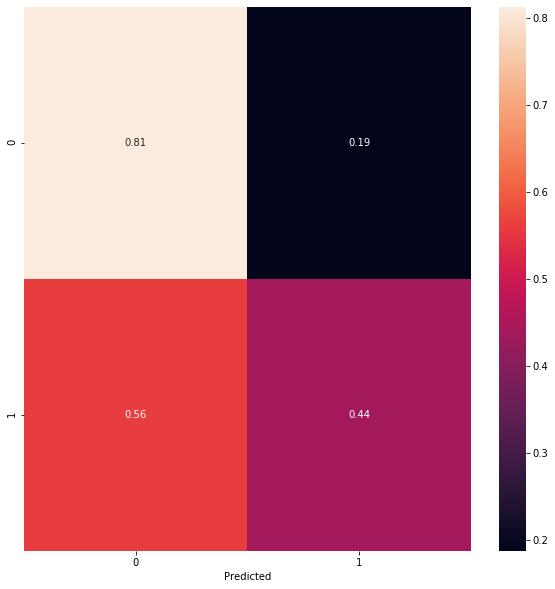

In [30]:
y_pred_LR = clf_log.predict(X_test)
evaluate_model(y_test, y_pred_LR)
matconfision(y_test, y_pred_LR)

El f1 score es de:  0.7108518911276069
El acc score es de:  0.7073170731707317
La precision es de:  0.7073170731707317
El f1 score es de:  0.7073170731707317


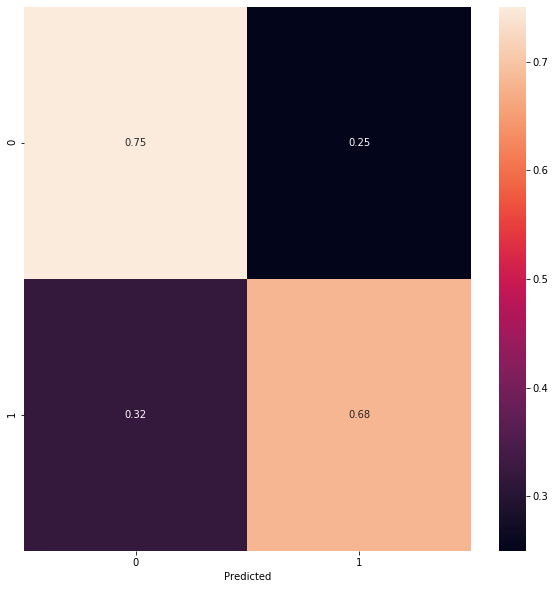

In [31]:
y_pred_RF = clasificador.predict(X_test)
evaluate_model(y_test, y_pred_RF)
matconfision(y_test, y_pred_RF)

## Cross validation con RandomForestClassifier

In [36]:
bosque = RandomForestClassifier(n_estimators = 500, random_state = 123)
scores = cross_val_score(bosque, X, y, cv = 20)

In [37]:
scores

array([0.36363636, 0.72727273, 0.36363636, 0.36363636, 0.5       ,
       0.4       , 0.8       , 0.7       , 0.5       , 0.6       ,
       0.6       , 0.6       , 0.6       , 0.8       , 0.8       ,
       0.3       , 0.6       , 0.7       , 0.5       , 0.3       ])

In [38]:
print("Accuracy: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std() * 2))

Accuracy: 0.56 (+/- 0.33)
